# Equation of State Search Code
The aim of the code in this file is to impose search parameters on all available EoS to select valid EoS for given values.

In [5]:
## required for loading in PYCBC ##
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir

     |████████████████████████████████| 6.7MB 5.3MB/s 
     |████████████████████████████████| 27.3MB 1.7MB/s 
     |████████████████████████████████| 61kB 38.6MB/s 
     |████████████████████████████████| 1.6MB 31.6MB/s 
     |████████████████████████████████| 890kB 31.8MB/s 
     |████████████████████████████████| 9.7MB 25.1MB/s 
     |████████████████████████████████| 81kB 45.1MB/s 
     |████████████████████████████████| 61kB 26.6MB/s 
     |████████████████████████████████| 3.2MB 30.7MB/s 
  Created wheel for ligo-segments: filename=ligo_segments-1.3.0-cp37-cp37m-linux_x86_64.whl size=85994 sha256=446849ed62b3e584bd487b4ce08bf199ae784ee698264df203686dc48ff054cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-1sh4gkl9/wheels/21/e8/4d/bfb61e2ececd2ba80c3b5c6691a8434358a655d6c2e7730ca9
  Created wheel for lscsoft-glue: filename=lscsoft_glue-2.0.0-cp37-cp37m-linux_x86_64.whl size=416782 sha256=448219fbb3babe23438bdd04e6df97314161ec607e2aa8f8e5fcda77fa1c431c
  Stored in directory: /t

In [11]:
## packages ##

import matplotlib
%matplotlib inline
import pylab
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from math import pi
from google.colab import files
import lalsimulation
import lal
import pandas as pd

#from google.colab import drive
#drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Equation of State: Upper mass limit checks
This code is used to check the upper limits of each model.

In [12]:
def EoS_MR_test (mass):
    m_pass = []
    m_fail = [] #mass
    rad_pass = [] #radius
    rad_fail =[]
    eos_modelP = []
    eos_modelF = []
    lambda_result = []
    i = 0    
    eos_names = np.array(lalsimulation.SimNeutronStarEOSNames)

    #for i in range (65):#
    for i in range(len(eos_names)):

            eos_int_ob = lalsimulation.SimNeutronStarEOSByName(eos_names[i])

            eos_ob = lalsimulation.CreateSimNeutronStarFamily(eos_int_ob)
            try:
              love_num = lalsimulation.SimNeutronStarLoveNumberK2(mass * lal.MSUN_SI, eos_ob)
            except:
                r = 0
                rad_fail.append(0)
                m_fail.append(mass)
                eos_modelF.append(eos_names[i])
                #print('The following model has failed:',eos_names[i])

            else:

              r = lalsimulation.SimNeutronStarRadius(mass * lal.MSUN_SI, eos_ob)

              rad_pass.append(r)
              m_pass.append(mass)
    
              rescale_const = lal.G_SI * mass * lal.MSUN_SI / (lal.C_SI*lal.C_SI * r)
              lamda = 2./3. * love_num * rescale_const**(-5.)
     
              eos_modelP.append(eos_names[i])
              lambda_result.append(lamda)
        
        
              i = i+1


    return eos_modelP,m_pass,rad_pass,lambda_result,eos_modelF,m_fail

In [16]:
result = EoS_MR_test(2.5) #change the mass value in the brackets to see how the number of valid EoS vary with mass

eos_MVar = pd.DataFrame(result).T
eos_MVar.columns=['Valid Model','Valid Mass','Valid Radius','Λ','Unsuitable Model','Unsuitable Mass']
#eos_MVar.to_csv('EoS_mass3-2.csv')
#files.download('EoS_mass3-2.csv')

eos_MVar


,Valid Model,Valid Mass,Valid Radius,Lambda,Unsuitable Model,Unsuitable Mass
0,MS1B,2.5,14533.3,28.7486,ALF1,2.5
1,MS1B_PP,2.5,14255.2,23.0352,ALF2,2.5
2,MS1_PP,2.5,14415.5,23.9875,ALF3,2.5
3,MS1,2.5,14687.6,30.1252,ALF4,2.5
4,None,None,None,None,AP1,2.5
...,...,...,...,...,...,...
56,None,None,None,None,SKOP,2.5
57,None,None,None,None,SLY2,2.5
58,None,None,None,None,SLY230A,2.5
59,None,None,None,None,SLY9,2.5


# Equation of State Sorting

In the function below, we aim to impose an upper and lower bound for tidal deformation, provided by the calculations carried out in the companion Jupyter notebook. Mass can be changed, and is currently set to GW170817 parameters.

In [17]:
def EoS_cleaning(mass,lower_bound,upper_bound):
    lambda_result = []
    eos_model = []
    eos_suitable = []
    eos_Notsuitable = [] 
    eos_NS_model = []

    eos_names = np.array(lalsimulation.SimNeutronStarEOSNames)
    
    i = 0
    for i in range (64):
        if i != 18: 
            eos_int_ob = lalsimulation.SimNeutronStarEOSByName(eos_names[i])

            eos_ob = lalsimulation.CreateSimNeutronStarFamily(eos_int_ob)
   
            love_num = lalsimulation.SimNeutronStarLoveNumberK2(mass * lal.MSUN_SI, eos_ob)
            r = lalsimulation.SimNeutronStarRadius(mass * lal.MSUN_SI, eos_ob)
    
            rescale_const = lal.G_SI * mass * lal.MSUN_SI / (lal.C_SI*lal.C_SI * r)
            lamda = 2./3. * love_num * rescale_const**(-5.)
          
            i = i+1
        else:
            pass

        if lamda <lower_bound:    
          eos_Notsuitable.append(lamda)
          eos_NS_model.append(eos_names[i])
        elif lamda <0:
          eos_Notsuitable.append(lamda)
          eos_NS_model.append(eos_names[i])
        elif lamda >upper_bound:
          eos_Notsuitable.append(lamda)
          eos_NS_model.append(eos_names[i])
        else:
          lambda_result.append(lamda)
          eos_model.append(eos_names[i])

    return eos_model, lambda_result,eos_NS_model,eos_Notsuitable

In [21]:
eos_c = EoS_cleaning(1.36,0,30000)
Suitable_EoS = pd.DataFrame(eos_c)
Final = np.transpose(Suitable_EoS.head())
Final.columns=['Suitable EoS','Λ','Unsuitable EoS','Unsuitable Λ']

#Final.to_csv('GW170817_Radius.csv')
#files.download('GW170817_Radius.csv')

Final

,Suitable EoS,Λ,Unsuitable EoS,Unsuitable Λ
0,ALF2,119.1,SQM2,-168.77
1,ALF3,891.184,SQM3,-84.5916
2,ALF4,148.042,WFF1,-628.554
3,AP1,371.668,None,None
4,AP2,82.7205,None,None
...,...,...,...,...
56,SKOP,578.934,None,None
57,SLY2,443.108,None,None
58,SLY230A,376.071,None,None
59,SLY9,397.674,None,None


In [ ]:
#Final.sort_values(by='Lambda', ascending=True, inplace=False, na_position='last')

# Equation of State: Mass & Radius
The function calculates the mass and radius of a neutron star binary merger 

In [ ]:
def EOS_mass_radius():
    m_pass = []
    m_fail = [] 
    rad_pass = [] 
    rad_fail =[]
    eos_modelP = []
    eos_modelF = []
    lambda_result = []

    eos_FM = {}
    eos_PM = {}
    eos_P = {}

   
    i = 0    
    
    eos_names = np.array(lalsimulation.SimNeutronStarEOSNames)
    eos_TEST0={}
    eos_TEST0['EOS'] =[]
    eos_TEST0['Radii'] = []
    eos_TEST0['Masses'] = []

    
    for mass in (1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.):
    
      for i in range (len(eos_names)):

            eos_int_ob = lalsimulation.SimNeutronStarEOSByName(eos_names[i])
            eos_ob = lalsimulation.CreateSimNeutronStarFamily(eos_int_ob)
            

            try:
              love_num = lalsimulation.SimNeutronStarLoveNumberK2(mass * lal.MSUN_SI, eos_ob)
            except:
                eos_FM.update({eos_names[i]:mass})             
                r = 0
                rad_fail.append(0)
                m_fail.append(mass)
                eos_modelF.append(eos_names[i])


            else:

              r = lalsimulation.SimNeutronStarRadius(mass * lal.MSUN_SI, eos_ob)

              rad_pass.append(r)
              m_pass.append(mass)
    
              rescale_const = lal.G_SI * mass * lal.MSUN_SI / (lal.C_SI*lal.C_SI * r)
              lamda = 2./3. * love_num * rescale_const**(-5.)
     
              eos_modelP.append(eos_names[i])
              lambda_result.append(lamda)

                               
              eos_TEST0['EOS'].append(eos_names[i])
              eos_TEST0['Masses'].append(mass)
              eos_TEST0['Radii'].append(r)

              i = i+1

              

    return eos_TEST0

In [ ]:
output = EOS_mass_radius()

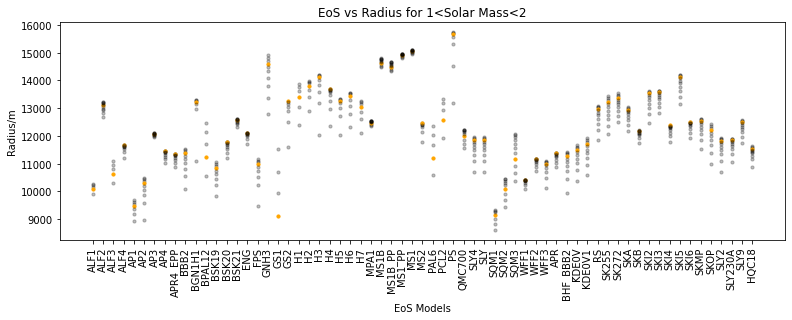

In [ ]:
eos_rad = [output.get('EOS'),output.get('Radii')]
eos_mas = [output.get('EOS'),output.get('Masses')]
mas = eos_mas[1]
rad = eos_rad[1]
eos_e = eos_rad[0]

f = plt.figure()
f.set_figwidth(13)

for i in range(617):
 
  if mas[i] ==1.3:
    plt.scatter(eos_e[i],rad[i],s=10,c='orange')
  else:
    plt.scatter(eos_e[i],rad[i],s=10,c='black',alpha=0.25)
      
  
plt.xticks(rotation='vertical')
plt.ylabel('Radius/m')
plt.xlabel('EoS Models')
plt.title('EoS vs Radius for 1<Solar Mass<2')
plt.show()

# Equation of State: Mass & Lambda
The function calculates the mass and lambda of a neutron star binary merger

In [ ]:
def EOS_mass_lambda():
    m_pass = []
    m_fail = [] 
    rad_pass = [] 
    rad_fail =[]
    eos_modelP = []
    eos_modelF = []
    lambda_result = []
   # eos_FR = {}
    eos_FM = {}
    eos_PM = {}
    eos_P = {}
   # eos_TEST0 = {}
   
    i = 0    
    
    eos_names = np.array(lalsimulation.SimNeutronStarEOSNames)
    eos_TEST0={}
    eos_TEST0['EOS'] =[]
    eos_TEST0['Masses'] = []
    eos_TEST0['Lambda'] = []
    
    for mass in (1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.):
    
      for i in range (len(eos_names)):

            eos_int_ob = lalsimulation.SimNeutronStarEOSByName(eos_names[i])
            eos_ob = lalsimulation.CreateSimNeutronStarFamily(eos_int_ob)
            

            try:
              love_num = lalsimulation.SimNeutronStarLoveNumberK2(mass * lal.MSUN_SI, eos_ob)
            except:
                eos_FM.update({eos_names[i]:mass})             
                r = 0
                rad_fail.append(0)
                m_fail.append(mass)
                eos_modelF.append(eos_names[i])

            else:

              r = lalsimulation.SimNeutronStarRadius(mass * lal.MSUN_SI, eos_ob)

              rad_pass.append(r)
              m_pass.append(mass)
    
              rescale_const = lal.G_SI * mass * lal.MSUN_SI / (lal.C_SI*lal.C_SI * r)
              lamda = 2./3. * love_num * rescale_const**(-5.)
     
              eos_modelP.append(eos_names[i])
              lambda_result.append(lamda)

                               
              eos_TEST0['EOS'].append(eos_names[i])
              eos_TEST0['Masses'].append(mass)
              #eos_TEST0['Radii'].append(r)
              eos_TEST0['Lambda'].append(lamda)

              i = i+1

              

    return eos_TEST0

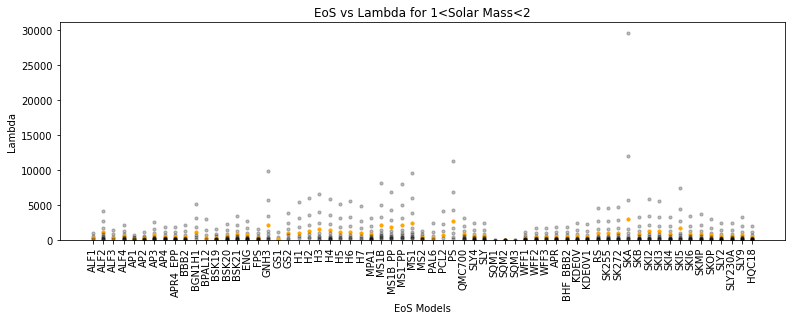

In [ ]:
out = EOS_mass_lambda()

eos_lam = [out.get('EOS'),out.get('Lambda')]
lam = eos_lam[1]
eos_e = eos_lam[0]

f = plt.figure()
f.set_figwidth(13)
for i in range(617):
  if mas[i] ==1.3:
    plt.scatter(eos_e[i],lam[i],s=10,c='orange')
  else:
    plt.scatter(eos_e[i],lam[i],s=10,c='black',alpha=0.25)
plt.xticks(rotation='vertical')
plt.ylabel('Lambda')
plt.ylim(0)
plt.xlabel('EoS Models')
plt.title('EoS vs Lambda for 1<Solar Mass<2')
plt.show()